In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import optimize as opt
import func
import preprocess

In [44]:
# Data sample
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()


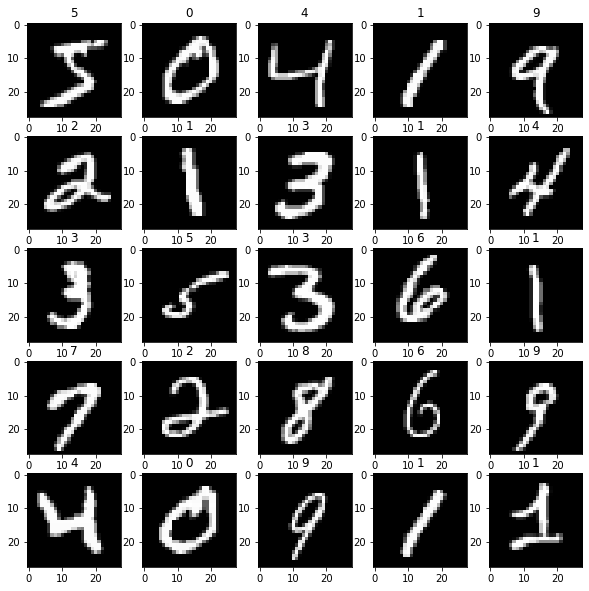

In [45]:
# Plot a sample of the data
import random
plt.figure(figsize = (10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    id = random.randint(0, len(x_train))
    plt.imshow(x_train[i], cmap = 'gray')
    plt.title(y_train[i])

In [46]:
# Logistic regression
def _cost(theta, x, y, lambda_):
    SAMPLE_SIZE = np.size(x, 0)
    reg = lambda_ / (2 * SAMPLE_SIZE) * np.sum(np.square(theta))
    y_hat = func.sigmoid(x @ theta)
    c = -func.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
    return c + reg

In [47]:
def _grad(theta, x, y, lambda_):
    SAMPLE_SIZE = np.size(x, 0)
    y_hat = func.sigmoid(x @ theta)
    grad = (x.T @ (y_hat - y)) / SAMPLE_SIZE + lambda_ / SAMPLE_SIZE * theta
    return grad

In [48]:
def _gradient_decent(x, y, theta, lambda_, learning_rate, iterations, **kwargs):
    SAMPLE_SIZE = np.size(x, 0)
    if 'plot_cost' in kwargs:
        plot = kwargs['plot_cost']
    else:
        plot = False
    for i in range(iterations):
        theta -= learning_rate * _grad(theta, x, y, lambda_)
        if plot:
            cost = _cost(theta, x, y, lambda_)
            costs = [] if i == 0 else costs + [cost]
    if plot:
        plt.plot(costs)

In [49]:
def fit(x, y, **kwargs): # Using one vs all

    if type(x) != np.ndarray:
        x = np.array(x)
    if type(y) != np.ndarray:
        y = np.array(y)

    SAMPLE_SIZE = np.size(x, 0)
    SIZE = np.size(x)
    if 'lambda_' not in kwargs:
        lambda_ = 0
    else:
        lambda_ = kwargs['lambda_']

    if 'iterations' not in kwargs:
        iterations = 1000
    else:
        iterations = kwargs['iterations']

    if 'scaling_method' not in kwargs:
        scaling_method = None
    else:
        scaling_method = kwargs['scaling_method']

        if scaling_method != 'normalize':
            scaling_method = 'standardize'
    
    if 'method' not in kwargs:
        method = 'BFGS'
    else:
        method = kwargs['method']

    # Data preprocessing
    x = np.reshape(x, (SAMPLE_SIZE, SIZE // SAMPLE_SIZE))
    #x.reshape(SAMPLE_SIZE, SIZE // SAMPLE_SIZE) # Make sure x is a 2D array
    
    if scaling_method is not None:
        if scaling_method == 'standardize':
            x, mean, std = preprocess.stardardize(x)
            scaling = (scaling_method, mean, std)
        if scaling_method == 'normalize':
            x, max, min = preprocess.normalize(x)
            scaling = (scaling_method, max, min)

    x = np.hstack((np.ones((SAMPLE_SIZE, 1)), x))
        
    y = np.array(pd.get_dummies(y))


    res = []
    for i in range(y.shape[1]):
        y_i = y[:, i]
        theta = preprocess.init_theta(x.shape[1])
        if 'use_gradient_descent' in kwargs:
            use_gradient_descent = kwargs['use_gradient_descent']
        else:
            use_gradient_descent = False
        if use_gradient_descent:
            theta = _gradient_decent(x, y_i, lambda_, 0.1, iterations=iterations)
        else:
            theta = opt.minimize(fun= _cost, x0= theta,args= (x, y_i, lambda_), jac = _grad, method=method, options= {'maxiter': iterations}).x
        res.append(theta)
    return np.array(res), scaling

In [50]:
def predict(x, theta, scaling):
    '''Can only predict 1 sample at a time'''
    if scaling[0] == 'standardize':
        x = (np.array(x) - scaling[1]) / scaling[2]
    elif scaling[0] == 'normalize':
        max = scaling[1]
        min = scaling[2]
        x = (np.array(x) - min) / (max - min)
    else:
        x = np.array(x)
    x = np.hstack((np.array([1]).reshape(1, 1), np.reshape(x, (1, np.size(x)))))
    return np.argmax(func.sigmoid(x @ theta.T))

In [51]:
all_theta, scaling = fit(x = x_train[:5000], y = y_train[:5000], scaling_method='normalize', method='BFGS', iterations=50, lambda_ = 0.1)

In [52]:
def predict_all(x, y, theta, scaling):
    correct = 0
    TEST_SIZE = np.size(x, 0)
    for i in range(TEST_SIZE):
        correct += predict(x[i], theta, scaling) == y[i]
    return correct / TEST_SIZE
print('accuracy: ', predict_all(x_test, y_test, all_theta, scaling))

accuracy:  0.8732


In [53]:
def learning_curve(x_train, y_train, x_test, y_test, lambda_):
    SAMPLE_SIZE = np.size(x_train, 0)
    train_accuracy = []
    test_accuracy = []
    for j in range(1, SAMPLE_SIZE, SAMPLE_SIZE // 20):
        x = x_train[:j]
        y = y_train[:j]
        theta, scale = fit(x, y, lambda_=lambda_, scaling_method = 'standardize', method = 'BFGS', iterations = 20)
        train_accuracy.append(predict_all(x, y, theta, scale))
        test_accuracy.append(predict_all(x_test, y_test, theta, scale))
    train_accuracy = pd.Series(train_accuracy)
    test_accuracy = pd.Series(test_accuracy)
    plt.plot(train_accuracy, label='train')
    plt.plot(test_accuracy, label='test')

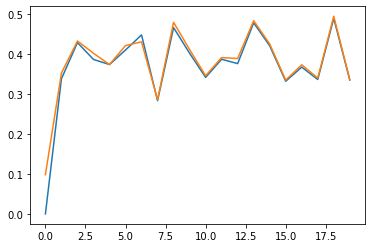

In [54]:
learning_curve(x_train, y_train, x_test, y_test, lambda_ = 1)

In [55]:
from logistic_regression import LogisticRegression
lr = LogisticRegression()
lr.set_x(x_train)
lr.set_y(y_train)
lr.set_lambda(0.1)
lr.set_iter_num(50)
lr.set_scaling_method('standardize')
lr.fit()

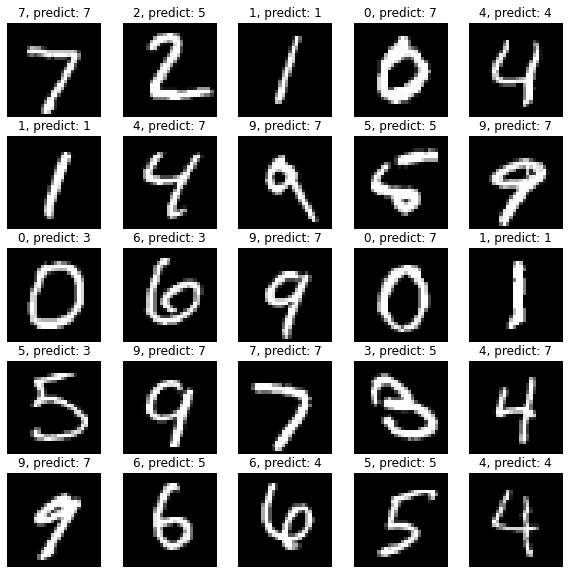

In [56]:
plt.figure(figsize = (10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    id = random.randint(0, len(x_test))
    plt.axis('off')
    plt.imshow(x_test[i], cmap = 'gray')
    plt.title('{}, predict: {}'.format(y_test[i], lr.predict(x_test[i])))